# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")

metadata.file = metadata.file.str.replace("/pstore/data/DS4/", "/projects/site/pred/data_science/year/2022/immunological_synapse/")

CPU times: user 2.6 s, sys: 202 ms, total: 2.8 s
Wall time: 2.92 s


In [6]:
row_index = metadata.set.isin(["train","validation","test"]) 

metadata = metadata.loc[row_index,:].reset_index(drop = True)

metadata

,file,experiment,donor,condition,object_number,set,label
0,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


['B_cell' 'B_T_cell_in_one_layer' 'Multiplets' 'Synapses_with_signaling'
 'T_cell_with_B_cell_fragments' 'T_cell' 'No_cell_cell_interaction'
 'Synapses_without_signaling' 'T_cell_with_signaling']


<AxesSubplot:>

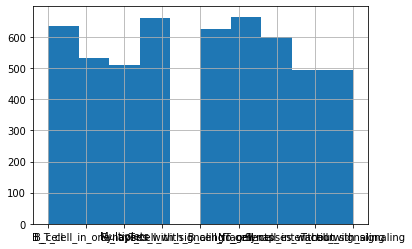

In [7]:
print(metadata.label.unique())
metadata.label.hist()

lets plot a random image per class

B_T_cell_in_one_layer
B_cell
Multiplets
No_cell_cell_interaction
Synapses_with_signaling
Synapses_without_signaling
T_cell
T_cell_with_B_cell_fragments
T_cell_with_signaling


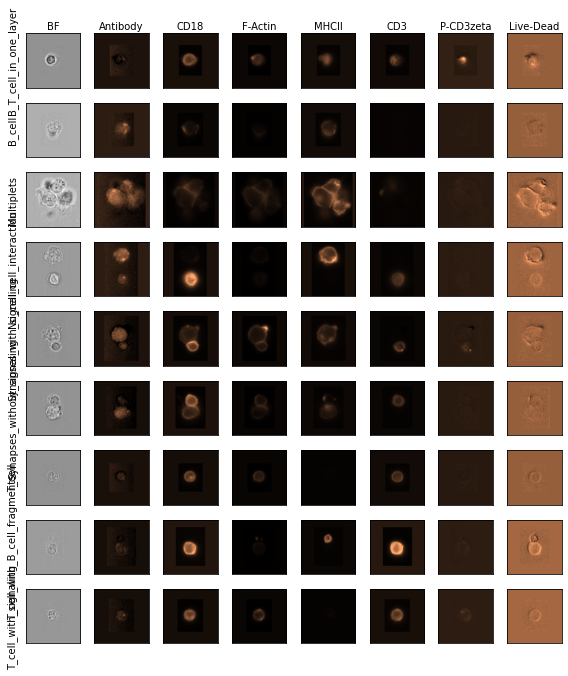

In [8]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 3)).reset_index(drop = True) ,  
                              figsize = (8,len(metadata.label.unique())),
                          channels = ["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper", "copper", "copper"],
                    image_size = 128)


Set all random seeds to the specific value, so the results are more reproducable

In [9]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [10]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 160

In [11]:
batch_size = 128
num_workers = 4
device="cuda"

In [12]:
channel_importance = pd.read_csv("channel_importance.csv")

In [13]:
from sklearn.preprocessing import MinMaxScaler
interpretation_methods = ["PXPermute", "Occlusion", "GuidedGradCAM", "DeepLift", "IntegratedGradients", "LRP"]
channel_importance.loc[:, interpretation_methods] = MinMaxScaler().fit_transform(channel_importance.loc[:, interpretation_methods])

channel_importance

,fold,channel,PXPermute,DeepLift,LRP,GuidedGradCAM,IntegratedGradients,Occlusion
0,1,BF,0.161485,0.362150,0.482151,0.154770,0.278642,0.086404
1,1,Antibody,0.121280,0.431038,0.615916,0.582579,0.273206,0.088344
2,1,CD18,0.125171,0.237442,0.484931,0.524043,0.247015,0.037002
3,1,F-Actin,0.111648,0.202214,0.493383,0.327392,0.205009,0.013363
4,1,MHCII,0.659918,0.421273,0.567049,0.000000,0.380313,0.250058
5,1,CD3,1.000000,0.210269,0.460546,0.302400,0.195405,0.954592
6,1,P-CD3zeta,0.811514,0.279507,0.859905,0.660856,0.214588,0.317143
7,1,Live-Dead,0.101375,0.398805,0.610754,0.691084,0.449760,0.121222
8,3,BF,0.015130,0.529919,0.667253,0.819149,0.447298,0.051435
9,3,Antibody,0.054948,0.322012,0.550609,0.667404,0.331210,0.052035


<AxesSubplot:xlabel='variable', ylabel='value'>

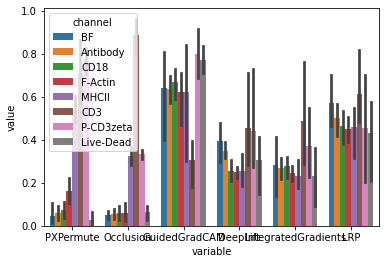

In [14]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            order = interpretation_methods,
            hue = "channel")

<AxesSubplot:ylabel='channel'>

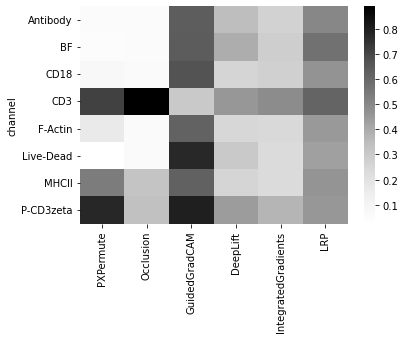

In [15]:
sns.heatmap(channel_importance.groupby(["channel"]).mean().loc[:,interpretation_methods], cmap = "Greys")

In [16]:
def select_top_channels(channel_importance, method, num_top_channels):
    grouped_importance = channel_importance.loc[:,["channel",method]].groupby("channel").mean()
    grouped_importance = grouped_importance.sort_values(by=method, ascending = False) 
    selected_channels = grouped_importance.index[:num_top_channels]
    selected_channels = [int(ch.replace("Ch","")) for ch in selected_channels]
    return selected_channels

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [18]:
def get_statistics(dataloader, selected_channels, device="cuda"):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels).to(device)
    statistics["p99"] = torch.zeros(nmb_channels).to(device)
    for data_l in dataloader:
        image, _ = data_l
        image = image.to(device)
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))
        statistics[k] = statistics[k].to("cpu")

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [19]:
set_of_interesting_classes = metadata.label.unique().tolist()
label_map = dict(zip(sorted(set(set_of_interesting_classes)), np.arange(len(set(set_of_interesting_classes)))))

In [20]:
channel_importance.channel = channel_importance.channel.replace({
    "BF":"Ch0",
    "Antibody":"Ch1",
    "CD18":"Ch2",
    "F-Actin":"Ch3",
    "MHCII":"Ch4",
    "CD3":"Ch5",
    "P-CD3zeta":"Ch6",
    "Live-Dead":"Ch7",
})

In [21]:
interpretation_methods = {
    "stainfree":[0],
    "PXPermute":[0,4,5,6],
    "all_channels":list(range(8)),
}

In [22]:
channel_importance.channel.unique()

array(['Ch0', 'Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7'],
      dtype=object)

In [23]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

num_all_channels = len(channel_importance.channel.unique())

results_with_stain_free_comparison = pd.DataFrame(columns = ["method",
                                                         "f1_micro",
                                                         "f1_macro",
                                                         "accuracy",
                                                        "fold_num"] + channel_importance.channel.unique().tolist())


for met in interpretation_methods:
    selected_channels = interpretation_methods[met]
    selected_channels.sort()
    train_index, test_index, _, _ = train_test_split(metadata.index, 
                                                    metadata.label.tolist(), 
                                                    stratify = metadata.label.tolist(),
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=seed_value)
    skf = StratifiedKFold(n_splits=5,shuffle=False)
    fold_num = 1
    for train_index, validation_index in skf.split(train_index.tolist(), 
                            metadata.loc[train_index, "label"].replace(label_map)):

        print(met, selected_channels, fold_num)

        print("sizes: train", len(train_index), 
              "validation", len(validation_index), 
              "sizes: test", len(test_index))


        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose([ ] ))
        train_loader = DataLoader(train_dataset, 
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers,
                                  pin_memory=True)
        statistics = get_statistics(train_loader, selected_channels=selected_channels)
        train_loader = None

        stats = dict()
        stats["lower_bound"] = statistics['p01']
        stats["upper_bound"] = statistics['p99']

        train_transform = [ 
                    MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                            max_in =  stats["upper_bound"] , 
                                            min_out =  0. , 
                                            max_out =  1.),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    AddGaussianNoise(mean=0., std=0.01),
            ]

        validation_transform =  [ 
                    MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                            max_in =  stats["upper_bound"] , 
                                            min_out =  0. , 
                                            max_out =  1.),
            ]

        test_transform =  [ 
                    MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                            max_in =  stats["upper_bound"] , 
                                            min_out =  0. , 
                                            max_out =  1.),
            ]


        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor, 
                                     reshape_size=reshape_size,
                                     transform= transforms.Compose(train_transform))

        validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor, 
                                     reshape_size=reshape_size,
                                     transform= transforms.Compose(validation_transform))

        test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor, 
                                     reshape_size=reshape_size,
                                     transform= transforms.Compose(test_transform))

        print("initializing a model with,", len(selected_channels),
              "channels and", len(set_of_interesting_classes), "classses")
        resnet18_modified = PretrainedModel(num_channels = len(selected_channels),
                                            num_classes = len(set_of_interesting_classes), 
                                            pretrained = True)

        lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

        epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                                         name =  "valid_f1_micro", 
                                         on_train = False,
                                         lower_is_better = False)

        epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                                         name =  "valid_f1_macro", 
                                         on_train = False,
                                         lower_is_better = False)

        early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                                           patience=30, 
                                           threshold=0.0001, 
                                           threshold_mode='rel', 
                                           lower_is_better=False)

        checkpoint = Checkpoint(f_params='synapse_formation_DL_method_stain_free_vs_PXPermute.pth',
                                    monitor='valid_f1_macro_best', load_best=True)

        net = NeuralNetClassifier(    
                resnet18_modified.cuda(), 
                criterion=nn.CrossEntropyLoss,
                lr=0.001,
                batch_size=batch_size,
                max_epochs=1000,
                optimizer=optim.Adam,
                iterator_train__shuffle=True,
                iterator_train__num_workers=num_workers,
                iterator_valid__shuffle=False,
                iterator_valid__num_workers=2,
                callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
                           epoch_scoring_f1_macro, 
                           early_stopping, checkpoint],
                train_split=predefined_split(validation_dataset),
                device="cuda",
                verbose=0,
                warm_start=True)
        net = net.fit(train_dataset, y = None)

        net.module.load_state_dict(torch.load('synapse_formation_DL_method_stain_free_vs_PXPermute.pth')) 


        preds = net.predict(test_dataset)

        results = {
            "method":met,
            "f1_micro":f1_score(test_dataset.metadata.label.replace(label_map), preds, average="micro"),
            "f1_macro":f1_score(test_dataset.metadata.label.replace(label_map), preds, average="macro"),
            "accuracy":accuracy_score(test_dataset.metadata.label.replace(label_map), preds),
            "fold_num":fold_num
        }

        for ch in range(num_all_channels):
            if ch in selected_channels:
                results["Ch"+str(ch)] = 1
            else:
                results["Ch"+str(ch)] = 0

        results_with_stain_free_comparison = results_with_stain_free_comparison.append(results,ignore_index = True)

        print(results_with_stain_free_comparison.groupby("method").mean())
        net = None
        resnet18_modified = None
        torch.cuda.empty_cache()
        results_with_stain_free_comparison.to_csv("results_with_stain_free_comparison.csv", index = False)

        print("---------------------------"*3)
        fold_num = fold_num + 1

stainfree [0] 1
sizes: train 3340 validation 836 sizes: test 1045
statistics used: {'p01': tensor([0.1826]), 'p99': tensor([0.2086])}
initializing a model with, 1 channels and 9 classses
           f1_micro  f1_macro  accuracy
method                                 
stainfree  0.745455  0.728831  0.745455
---------------------------------------------------------------------------------
stainfree [0] 2
sizes: train 3341 validation 835 sizes: test 1045
statistics used: {'p01': tensor([0.1818]), 'p99': tensor([0.2074])}
initializing a model with, 1 channels and 9 classses
           f1_micro  f1_macro  accuracy
method                                 
stainfree   0.71244  0.698791   0.71244
---------------------------------------------------------------------------------
stainfree [0] 3
sizes: train 3341 validation 835 sizes: test 1045
statistics used: {'p01': tensor([0.1808]), 'p99': tensor([0.2060])}
initializing a model with, 1 channels and 9 classses
           f1_micro  f1_macro  accu

In [24]:
results_with_stain_free_comparison

,method,f1_micro,f1_macro,accuracy,fold_num,Ch0,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7
0,stainfree,0.745455,0.728831,0.745455,1,1,0,0,0,0,0,0,0
1,stainfree,0.679426,0.668752,0.679426,2,1,0,0,0,0,0,0,0
2,stainfree,0.876555,0.872123,0.876555,3,1,0,0,0,0,0,0,0
3,stainfree,0.761722,0.751723,0.761722,4,1,0,0,0,0,0,0,0
4,stainfree,0.878469,0.875683,0.878469,5,1,0,0,0,0,0,0,0
5,PXPermute,0.944498,0.943677,0.944498,1,1,0,0,0,1,1,1,0
6,PXPermute,0.933014,0.931051,0.933014,2,1,0,0,0,1,1,1,0
7,PXPermute,0.944498,0.942588,0.944498,3,1,0,0,0,1,1,1,0
8,PXPermute,0.932057,0.930966,0.932057,4,1,0,0,0,1,1,1,0
9,PXPermute,0.920574,0.917141,0.920574,5,1,0,0,0,1,1,1,0


In [25]:
print(results_with_stain_free_comparison.groupby("method").mean().round(2))

              f1_micro  f1_macro  accuracy
method                                    
PXPermute         0.93      0.93      0.93
all_channels      0.94      0.94      0.94
stainfree         0.79      0.78      0.79


In [26]:
print(results_with_stain_free_comparison.groupby("method").std().round(2))

              f1_micro  f1_macro  accuracy
method                                    
PXPermute         0.01      0.01      0.01
all_channels      0.01      0.01      0.01
stainfree         0.09      0.09      0.09


now we calculate the statistics of every channel to later use for nomalizing the dataset

(0.6, 1.0)

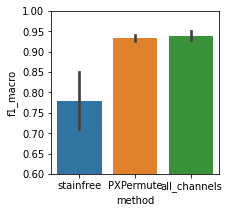

In [30]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(data = results_with_stain_free_comparison, 
            x = "method", 
            y = "f1_macro",
                 ax=ax)

ax.set_ylim(0.6,1)

In [28]:
results_with_stain_free_comparison.to_csv("results_with_stain_free_comparison.csv", index = False)

In [29]:
1

1